In [1]:
x=1

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
random.seed(123)

# MultiMIL

In [4]:
df = {}

In [5]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/trimodal/data/multigrate/cond_dim~16_kl~0.1_integ~3000_lr~0.0005_z_dim~16/0/adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 112925 × 24134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch', 'reference', 'type_of_query'
    uns: 'Modality_colors', 'Samplename_colors', 'l1_cell_type_colors', 'l2_cell_type_colors', 'neighbors', 'reference_colors', 'umap'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 'latent'
    layers: 'counts'
    obsp: 'connectivities', 'di

In [6]:
adata.obs['Site']

GCATTAGCATAAGCGG-1-s1d1     site1
TACAGGTGTTAGAGTA-1-s1d1     site1
AGGATCTAGGTCTACT-1-s1d1     site1
GTAGAAAGTGACACAG-1-s1d1     site1
TCCGAAAAGGATCATA-1-s1d1     site1
                            ...  
AAACCGCGTTTGAGGC-12-s4d9    site4
TGACTTAAGTTCCCGT-12-s4d9    site4
GCTGTACCACCGTTCC-12-s4d9    site4
ACACTTGCAACTAGAA-12-s4d9    site4
CACTTAAAGTCTGGGC-12-s4d9    site4
Name: Site, Length: 112925, dtype: category
Categories (3, object): ['site1', 'site2', 'site4']

In [7]:
X = adata[adata.obs['Site'] != 'site4'].obsm['latent']
X.shape

(73951, 16)

In [8]:
X_test = adata[adata.obs['Site'] == 'site4'].obsm['latent']
X_test.shape

(38974, 16)

In [9]:
y = adata[adata.obs['Site'] != 'site4'].obs['l2_cell_type'].values

In [10]:
y_true = adata[adata.obs['Site'] == 'site4'].obs['l2_cell_type'].values

In [11]:
clf = RandomForestClassifier(random_state=0, class_weight = "balanced_subsample", n_jobs=-1)

In [12]:
clf.fit(X, y)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=0)

In [13]:
y_pred = clf.predict(X_test)

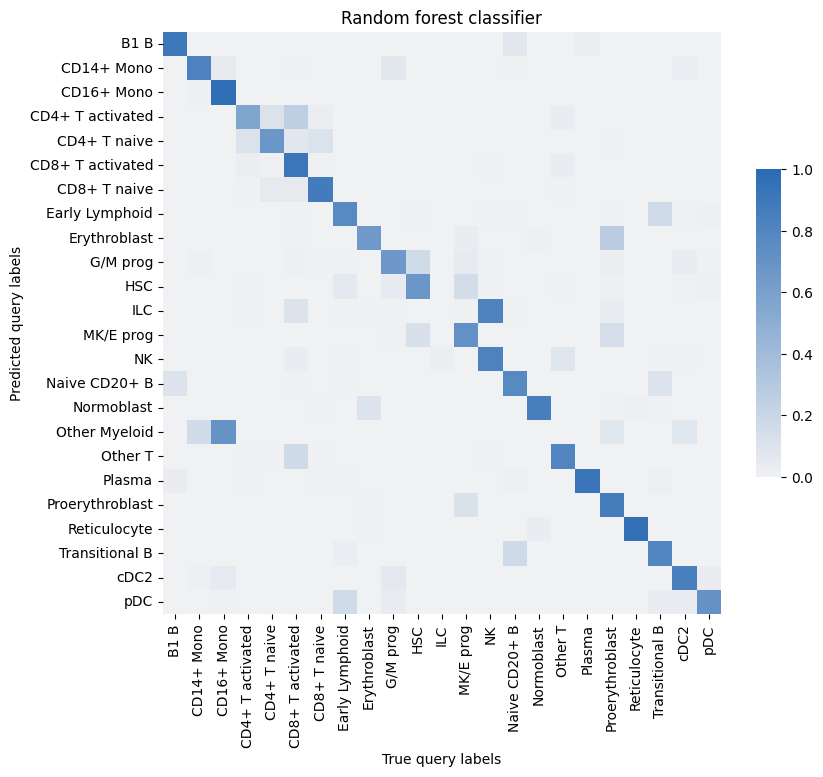

In [14]:
# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title('Random forest classifier')
plt.savefig('figures/knn_full_query.svg', bbox_inches='tight')

In [15]:
query = adata[adata.obs['Site'] == 'site4'].copy()

idx_atac_query = query.obs['Samplename'] == 'site4_donor9_multiome'
idx_scrna_query = query.obs['Samplename'] == 'site4_donor8_cite'
idx_snrna_query = query.obs['Samplename'] == 'site4_donor8_multiome'

idx_mutiome_query = query.obs['Samplename'] == 'site4_donor1_multiome'
idx_cite_query = query.obs['Samplename'] == 'site4_donor1_cite'

In [16]:
query.obs['reference'] = query.obs['reference'].astype(str)
query.obs.loc[idx_atac_query, 'reference'] = 'ATAC query'
query.obs.loc[idx_scrna_query, 'reference'] = 'scRNA query'
query.obs.loc[idx_snrna_query, 'reference'] = 'snRNA query'
query.obs.loc[idx_mutiome_query, 'reference'] = 'multiome query'
query.obs.loc[idx_cite_query, 'reference'] = 'CITE query'
query.obs['reference'] = query.obs['reference'].astype('category')

In [17]:
query.obs['reference'].cat.categories

Index(['ATAC query', 'CITE query', 'multiome query', 'query', 'scRNA query',
       'snRNA query'],
      dtype='object')

ATAC query
0.56


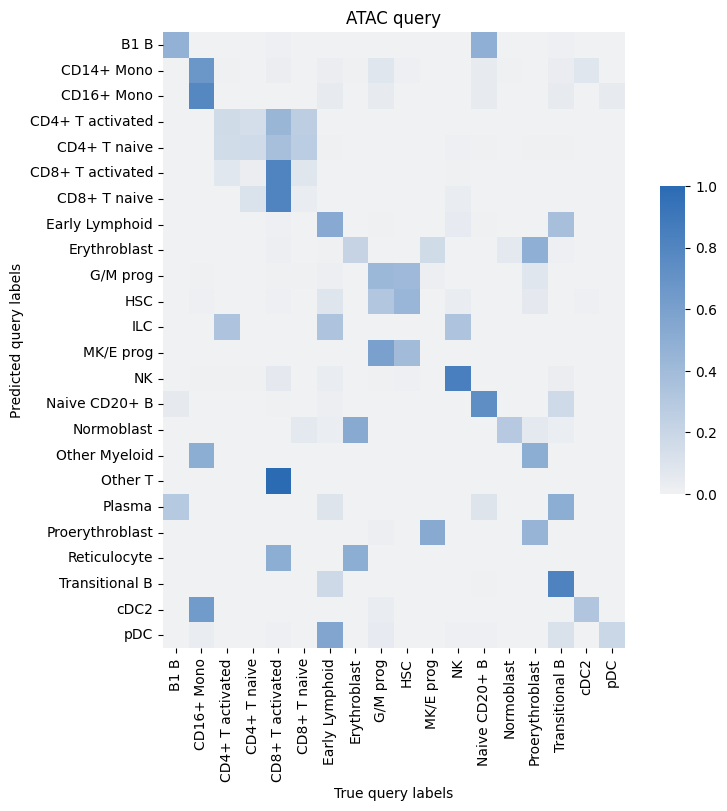

In [18]:
q = 'ATAC query'

tmp = query[query.obs['reference'] == q]
print(q)
X_test = tmp.obsm['latent']
y_pred = clf.predict(X_test)
y_true = tmp.obs['l2_cell_type'].values

acc = np.sum(y_true == y_pred)/len(y_pred)
print(acc)
df[q] = acc

# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title(q)
plt.savefig('figures/knn_atac_query.svg', bbox_inches='tight')

CITE query
0.8724340175953079


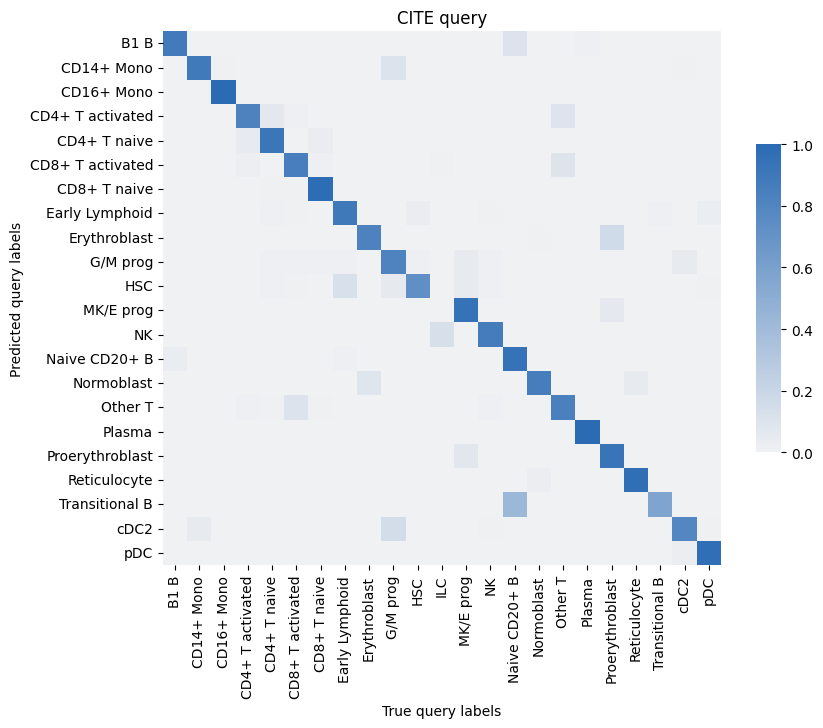

In [19]:
q = 'CITE query'

tmp = query[query.obs['reference'] == q]
print(q)
X_test = tmp.obsm['latent']
y_pred = clf.predict(X_test)
y_true = tmp.obs['l2_cell_type'].values

acc = np.sum(y_true == y_pred)/len(y_pred)
print(acc)
df[q] = acc

# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title(q)
plt.savefig('figures/knn_cite_query.svg', bbox_inches='tight')

snRNA query
0.769036046982584


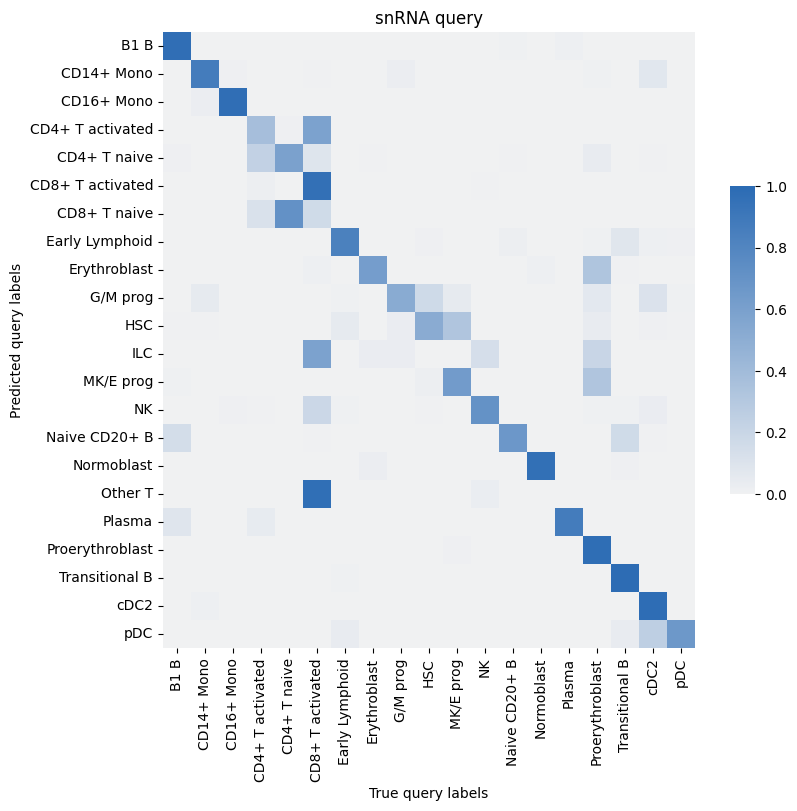

In [20]:
q = 'snRNA query'

tmp = query[query.obs['reference'] == q]
print(q)
X_test = tmp.obsm['latent']
y_pred = clf.predict(X_test)
y_true = tmp.obs['l2_cell_type'].values

acc = np.sum(y_true == y_pred)/len(y_pred)
print(acc)
df[q] = acc

# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title(q)
plt.savefig('figures/knn_snRNA_query.svg', bbox_inches='tight')

scRNA query
0.8569610587935862


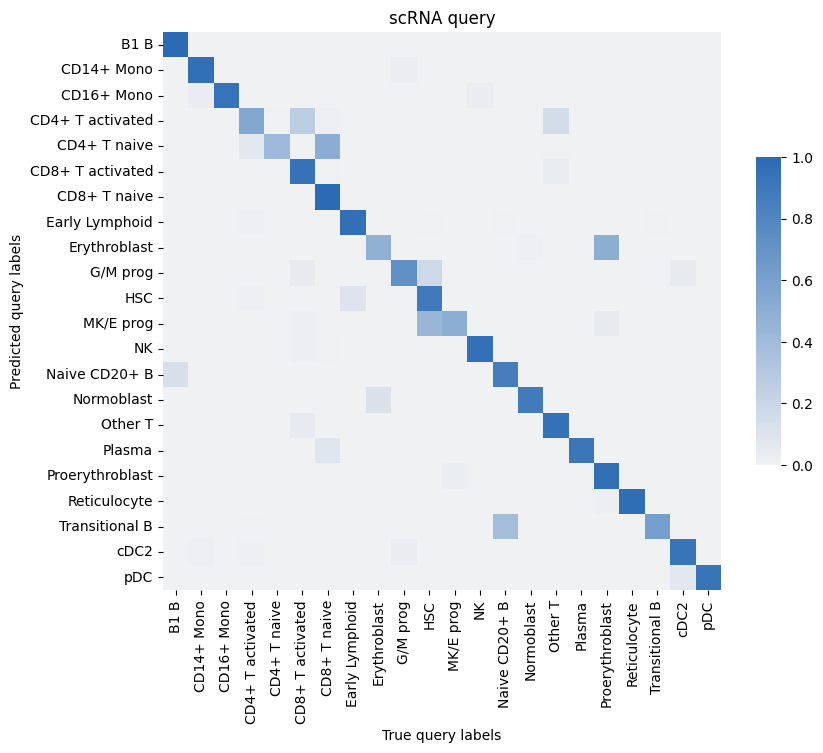

In [21]:
q = 'scRNA query'

tmp = query[query.obs['reference'] == q]
print(q)
X_test = tmp.obsm['latent']
y_pred = clf.predict(X_test)
y_true = tmp.obs['l2_cell_type'].values

acc = np.sum(y_true == y_pred)/len(y_pred)
print(acc)
df[q] = acc

# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title(q)
plt.savefig('figures/knn_scRNA_query.svg', bbox_inches='tight')

multiome query
0.7833728031908264


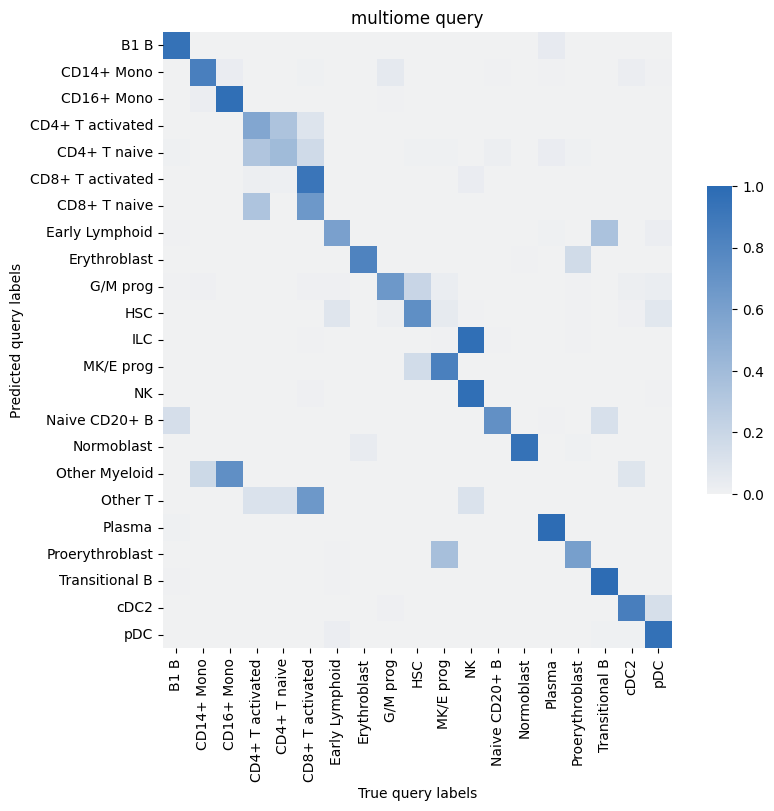

In [22]:
q = 'multiome query'

tmp = query[query.obs['reference'] == q]
print(q)
X_test = tmp.obsm['latent']
y_pred = clf.predict(X_test)
y_true = tmp.obs['l2_cell_type'].values

acc = np.sum(y_true == y_pred)/len(y_pred)
print(acc)
df[q] = acc

# adjusted from https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/ (accessed on 25.05.21)
confusion_matrix = pd.crosstab(
    y_true, 
    y_pred,
    rownames=["True query labels"],
    colnames=["Predicted query labels"],
)
confusion_matrix /= confusion_matrix.sum(0)

confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.columns), axis=1)
confusion_matrix = confusion_matrix.reindex(sorted(confusion_matrix.index.values))

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    vmax=1
)

ax.set_title(q)
plt.savefig('figures/knn_multiome_query.svg', bbox_inches='tight')

In [23]:
df

{'ATAC query': 0.56,
 'CITE query': 0.8724340175953079,
 'snRNA query': 0.769036046982584,
 'scRNA query': 0.8569610587935862,
 'multiome query': 0.7833728031908264}

In [24]:
df = pd.DataFrame(df, index=['accuracy'])
df

,ATAC query,CITE query,snRNA query,scRNA query,multiome query
accuracy,0.56,0.872434,0.769036,0.856961,0.783373


In [25]:
df.to_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/trimodal/metrics/data/knn_accuracies.csv')